In [3]:
import os
import numpy as np
from Env.DC_gym import DiscreteGymDC
from Nets.DQN import DQN
from Utils.memory import Memory
import gym
import tensorflow as tf
import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Sales prices
 - these probably need to be done more legitly later

In [6]:
# currently from thesis code, just copying iso & n butane to be same values
compound_names = ["Methane", "Ethane", "Propane", "Isobutane", "Butane",  "Iso-Pentane", "N-pentane"]
Molar_weights = np.array([16.043, 30.07, 44.097, 58.124, 58.124, 72.151, 72.151])
Heating_value = np.array([55.6,  51.9, 50.4, 49.5, 49.4,   55.2, 55.2]) #MJ/kg
Price_per_MBTU = np.array([2.83, 2.54, 4.27, 5.79, 5.31,  10.41, 10.41])  #  $/Million Btu

sales_prices = Price_per_MBTU*1055.06 * Heating_value  # now in $/kg
sales_prices

array([166011.58088, 139084.33956, 227057.35248, 302385.4713 ,
       276757.00884, 606271.23792, 606271.23792])

# ChemEng Env

In [7]:
COCO_file = "Env\ChemSepExample.fsd"
env = DiscreteGymDC(os.path.join(os.getcwd(), COCO_file), sales_prices, n_discretisations=3)
state = env.reset()
n_actions = env.n_actions

In [ ]:
state, reward, done, info = env.step(np.random.choice(env.legal_actions))

In [ ]:
"""PARAM"""
total_episodes = 100
target_updates = 50
mem_length = 200
gamma = 0.99
batch_size = 32

layer_size = 32
depth = 3

# Cartpole Env (just to test Agent)

env = gym.make('CartPole-v0')
env.reset()
n_actions = env.action_space.n

"""PARAM"""
total_episodes = 1000
target_updates = 200
mem_length = 100
gamma = 0.95
batch_size = 32

layer_size = 32
depth = 3

# Back to DQN tester general stuff

In [35]:
def eps_greedy(current_episode, total_episodes, start_probability=0.99, end_probability=0.01):
    epsilon = start_probability + (end_probability-start_probability)*current_episode/total_episodes
    random_number = np.random.sample(1)
    if epsilon > random_number: # exploit
        return True
    else: # explore
        return False

In [36]:
"""
# For testing with cartpole
tf.keras.backend.set_floatx('float64')
DQN_model = DQN(n_actions, env.observation_space.shape, layer_size=layer_size, depth = depth).model
#DQN_model = DQN(n_actions, env.observation_space.shape, schedule_lr=True, decay_steps=total_episodes/10).model
targetDQN_model = DQN(n_actions, env.observation_space.shape, layer_size=layer_size, depth = depth).model
memory = Memory(max_size=mem_length)
"""
tf.keras.backend.set_floatx('float64')
DQN_model = DQN(n_actions, env.State.state.shape, layer_size=layer_size, depth = depth).model
targetDQN_model = DQN(n_actions, env.State.state.shape, layer_size=layer_size, depth = depth).model
memory = Memory(max_size=mem_length)

In [37]:
#tf.keras.utils.plot_model(DQN_model, show_shapes=True)
None

# Populate memory

In [38]:
# when print error function is on, the errors seem to come in pairs?

In [39]:
# first populate memory with random experience
for i in range(mem_length):
    state = env.reset()
    done = False
    while not done:
        #action = env.action_space.sample()
        action = np.random.choice(env.legal_actions)
        next_state, reward, done, info = env.step(action)
        memory.add([state, action, reward, next_state, 1 - done])
        state = next_state

# Now learn

In [40]:
history = []
for i in range(total_episodes):
    state = env.reset()
    done = False
    k = 0
    total_reward = 0
    while not done:
        k += 1
        if eps_greedy(i, total_episodes*4/5) is True:
            DQN_predictions = DQN_model.predict(state[np.newaxis, :])
            mask = np.ones_like(DQN_predictions, bool)
            mask[:, env.legal_actions] = False
            DQN_predictions[mask] = None
            action = np.nanargmax(DQN_predictions)
        else:
            #action = env.action_space.sample()
            action = np.random.choice(env.legal_actions)
        
        # now take action
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        
        memory.add((state, action, reward, next_state, 1 - done))
        batch = memory.sample(batch_size)
        state_batch = np.array([each[0] for each in batch])
        action_batch = np.array([each[1] for each in batch])
        reward_batch = np.array([each[2] for each in batch])
        next_state_batch = np.array([each[3] for each in batch])
        done_batch = np.array([each[4] for each in batch])
        
        next_action = np.argmax(DQN_model.predict(next_state_batch), axis=1)
        y = DQN_model.predict(state_batch) # dummy values for actions that aren't taken
        y[np.arange(batch_size), action_batch] = reward_batch + done*gamma*targetDQN_model.predict(next_state_batch)[np.arange(batch_size), next_action]
        
        DQN_model.train_on_batch(x = state_batch, y=y)
  
    history.append(total_reward)         
            
    if i % target_updates == 0:
        targetDQN_model.set_weights(DQN_model.get_weights())
        print(f"Average reward of last {target_updates} episodes: {np.mean(history[-target_updates:])}")
        print(f"episode {i}/{total_episodes}")

Average reward of last 50 episodes: 26873.0
episode 0/1000
Average reward of last 50 episodes: 119817.12
episode 50/1000
Average reward of last 50 episodes: 511710.12
episode 100/1000
Average reward of last 50 episodes: 217282.76
episode 150/1000
Average reward of last 50 episodes: 1002074.14
episode 200/1000
Average reward of last 50 episodes: 925967.0
episode 250/1000
Average reward of last 50 episodes: 503641.72
episode 300/1000
Average reward of last 50 episodes: 315543.26
episode 350/1000
Average reward of last 50 episodes: 264837.22
episode 400/1000
Average reward of last 50 episodes: 528634.72
episode 450/1000
Average reward of last 50 episodes: 449217.04
episode 500/1000
Average reward of last 50 episodes: 440327.8
episode 550/1000
Average reward of last 50 episodes: 152677.84
episode 600/1000
Average reward of last 50 episodes: 540898.54
episode 650/1000
Average reward of last 50 episodes: 275544.96
episode 700/1000
Average reward of last 50 episodes: 560303.34
episode 750/100

In [41]:
def running_mean(x, N=20):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / N

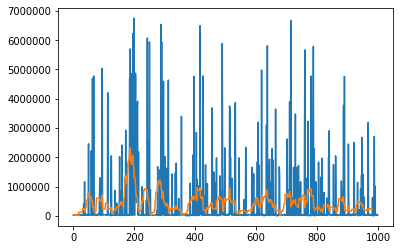

In [42]:
plt.plot(history)
plt.plot(running_mean(history))

In [26]:
test_hist = []
for _ in range(10):
    total_reward = 0
    done = False
    state = env.reset()
    while not done:
        action = np.argmax(DQN_model.predict(state[np.newaxis, :]))
        state, reward, done, info = env.step(action)
        total_reward += reward
    test_hist.append(total_reward)
env.close()
np.mean(test_hist)

AttributeError: 'DiscreteGymDC' object has no attribute 'render'

In [44]:
env.error_counter

{'total_solves': 5524, 'error_solves': 366}